<a href="https://colab.research.google.com/github/GuanRunwei/COMP6248-Deep-Learning/blob/exercises/DL_lab8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

In [ ]:
%matplotlib inline

import torchvision
import torchvision.transforms as transforms
import matplotlib.gridspec as gridspec    
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.autonotebook import tqdm
from itertools import chain

import numpy as np

device = "cuda:0" if torch.cuda.is_available() else "cpu"
batch_size = 256
image_dim = 784 #flattened

# dataset construction
transform = transforms.Compose([
    transforms.ToTensor(), # convert to tensor
    transforms.Lambda(lambda x: x.view(image_dim)) # flatten into vector
    ])

train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST'
    ,train=True
    ,download=True
    ,transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size
)


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw




Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw




Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw




Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
print(train_set.data.shape)
train_data = train_set.data
train_data = train_data.view(-1, image_dim)
train_data = torch.tensor(train_data, dtype = torch.float, device = device)
print(train_data.shape)

torch.Size([60000, 28, 28])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


torch.Size([60000, 784])


In [ ]:
class VAE_Encoder(nn.Module):
    '''
    simple encoder with a single hidden dense layer (ReLU activation)
    and linear projections to the diag-Gauss parameters
    '''
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(VAE_Encoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                     nn.ReLU())
        
        self.mu     = nn.Linear(hidden_dim, output_dim)
        self.logvar = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        encoder = self.encoder(x)
        mu, logvar = self.mu(encoder), self.logvar(encoder)
        return mu, logvar

class VAE_Decoder(nn.Module):
    '''
    simple decoder: single dense hidden layer (ReLU activation) followed by 
    output layer with a sigmoid to squish values
    '''
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(VAE_Decoder, self).__init__()
        self.latent_mapping = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, z):
        latent_z = self.latent_mapping(z)
        latent_z = F.relu(latent_z)
        out = self.decoder(latent_z)
        out = torch.sigmoid(out)
        return out

# Sampling function (using the reparameterisation trick)
def sample(mu, log_sigma2):
    eps = torch.randn(mu.shape[0], mu.shape[1], device=device)
    return mu + torch.exp(log_sigma2 / 2) * eps


#parameters
batch_size = 256
embedding_dim = 2
enc_hidden_units = 512
dec_hidden_units = 512
nEpoch = 10

# construct the encoder, decoder and optimiser
vae_enc = VAE_Encoder(image_dim, enc_hidden_units, embedding_dim).to(device)
vae_dec = VAE_Decoder(embedding_dim, dec_hidden_units, image_dim).to(device)
optimizer = optim.Adam(chain(vae_enc.parameters(), vae_dec.parameters()), lr=1e-3)

# training loop
for epoch in range(nEpoch):
    losses = []
    trainloader = tqdm(train_loader)

    for i, data in enumerate(trainloader, 0):
        inputs, _ = data
        inputs = inputs.to(device)
        optimizer.zero_grad()

        mu, log_sigma2 = vae_enc(inputs)
        z = sample(mu, log_sigma2)
        outputs = vae_dec(z)

        # E[log P(X|z)] - as images are binary it makes most sense to use binary cross entropy
        # we need to be a little careful - by default torch averages over every observation 
        # (e.g. each  pixel in each image of each batch), whereas we want the average over entire
        # images instead
        recon = F.binary_cross_entropy(outputs, inputs, reduction='sum') / inputs.shape[0]
        
        kl = 0 
        # kl = D_KL(Q(z|X) || P(z|X)) - calculate in closed form
        # Compute the term kl which is then added to the total loss
        # YOUR CODE HERE
        kl = - 0.5 * torch.sum(1 + log_sigma2 - mu.pow(2) - log_sigma2.exp()) / inputs.shape[0]
        
        loss = recon + kl
        loss.backward()
        optimizer.step()

        # keep track of the loss and update the stats
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)

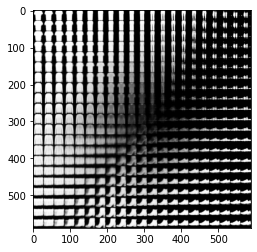

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

vae_enc.eval()
vae_dec.eval()
cnt = 21
latent_x = torch.linspace(-4, 4, cnt)
latent_y = torch.linspace(4, -4, cnt)
image_height = 28
image_width = 28

large_image = np.zeros((588, 588))
for i, x in enumerate(latent_x):
  for j, y in enumerate(latent_y):
    z = torch.tensor((x, y)).unsqueeze(0).to(device)
    output = vae_dec(z)
    output = output.cpu().detach().reshape(image_height,image_width)
    large_image[j*image_height:(j+1)*image_height, i*image_width:(i+1)*image_width] = output

plt.imshow(large_image, cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
class Encoder(nn.Module):
    '''
    simple encoder with no hidden dense layer
    '''
    def __init__(self, input_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)

    def forward(self, x):
        return self.fc(x)

class Decoder(nn.Module):
    '''
    simple decoder: single dense hidden layer followed by 
    output layer with a sigmoid to squish values
    '''
    def __init__(self, input_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.fc(x)
        x = torch.sigmoid(out)
        return x

enc_dim = 2
image_dim = 784  # [flattened]
nEpoch = 20

# construct the encoder, decoder and optimiser
enc = Encoder(image_dim, enc_dim).to(device)
dec = Decoder(enc_dim, image_dim).to(device)
optimizer = optim.Adam(chain(enc.parameters(), dec.parameters()), lr=1e-3)

# training loop
for epoch in range(nEpoch):
    losses = []
    trainloader = tqdm(train_loader)

    for i, data in enumerate(trainloader, 0):
        inputs, _ = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        
        z = enc(inputs)
        outputs = dec(z)

        loss = F.binary_cross_entropy(outputs, inputs, reduction='sum') / inputs.shape[0]
        loss.backward()
        optimizer.step()

        # keep track of the loss and update the stats
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)

In [ ]:
enc.eval()
dec.eval()
cnt = 21
latent_x = torch.linspace(-4, 4, cnt)
latent_y = torch.linspace(4, -4, cnt)
image_height = 28
image_width = 28

large_image = np.zeros((588, 588))
for i, x in enumerate(latent_x):
  for j, y in enumerate(latent_y):
    z = torch.tensor((x, y)).unsqueeze(0).to(device)
    output = dec(z)
    output = output.cpu().detach().reshape(image_height,image_width)
    large_image[j*image_height:(j+1)*image_height, i*image_width:(i+1)*image_width] = output

plt.imshow(large_image, cmap=plt.get_cmap('gray'))

plt.show()

NameError: ignored

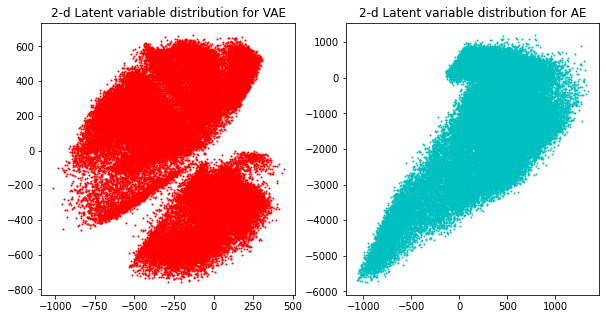

In [ ]:
latent1, _ = vae_enc(train_data)
latent1 = latent1.cpu().detach()

latent2 = enc(train_data)
latent2 = latent2.cpu().detach()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].scatter(latent1[:, 0], latent1[:, 1], c='r', s=1)
ax[0].set_title("2-d Latent variable distribution for VAE")
ax[1].scatter(latent2[:, 0], latent2[:, 1], c='c', s=1)
ax[1].set_title("2-d Latent variable distribution for AE")
plt.show()